## Notebook for comparing tests
### Testing distributions

This notebook is trying to compare different drift tests and highlight each strength. Every test is usefull! We just have to use it in a fitted scenario!

Import libraries

In [1]:
try:
    import evidently
except:
    !npm install -g yarn
    !pip install git+https://github.com/evidentlyai/evidently.git

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn import datasets, ensemble, model_selection

from evidently import ColumnMapping
from evidently.calculations.stattests import StatTest
from evidently.options import DataDriftOptions
from evidently.test_suite import TestSuite
from evidently.tests import *

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Prepare Datasets/Distributions

Now we are going to define four distributions with different types of dirfts for the two samples

In [ ]:
#function that will help us define sample and control group

def give_me_smp_cntr_df(sample1,sample2):
    """
    It recieves two arrays of the produced sample distributions and
    returns two dataframes that have he sample and control groups to test later the drift
    """
    sample_df = pd.DataFrame(np.array([sample1,sample2]).T,columns=['sample_group','control_group'])
    #initial dataset
    smp_df=sample_df['sample_group'].reset_index().rename(columns={'sample_group': "test_group"})
    #control dataset
    cntr_df=sample_df['control_group'].reset_index().rename(columns={'control_group': "test_group"})
    return smp_df,cntr_df


In [45]:
# General gamma distirbution

a, c = 3, -1.02
#defining sample 1
r = stats.gengamma.rvs(a, c, size=1000)

a, c = 3, -1.32
#defining sample 2
r2 = stats.gengamma.rvs(a, c, size=1000)


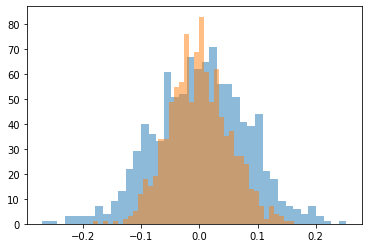

In [9]:
# Normal distirbution

mu, sigma = 0, 0.08 # mean and standard deviation
r3 = np.random.normal(mu, sigma, 1000)

mu, sigma = 0, 0.05 # mean and standard deviation
r4 = np.random.normal(mu, sigma, 1000)

sample_df_2 = pd.DataFrame(np.array([r3,r4]).T,columns=['sample_group','control_group'])
#initial dataset
smp_df2=sample_df_2['sample_group'].reset_index().rename(columns={'sample_group': "test_group"})
#control dataset
cntr_df2=sample_df_2['control_group'].reset_index().rename(columns={'control_group': "test_group"})

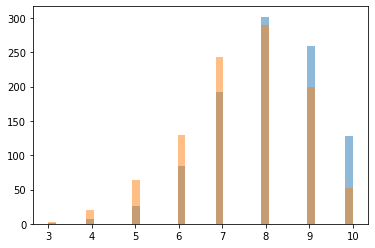

In [10]:
# Discrete bionmal

n=10
p=0.8

data_binom = stats.binom.rvs(10,0.8,size=1000)
data_binom2 = stats.binom.rvs(10,0.75,size=1000)

sample_df_3 = pd.DataFrame(np.array([data_binom,data_binom2]).T,columns=['sample_group','control_group'])
#initial dataset
smp_df3=sample_df_3['sample_group'].reset_index().rename(columns={'sample_group': "test_group"})
#control dataset
cntr_df3=sample_df_3['control_group'].reset_index().rename(columns={'control_group': "test_group"})

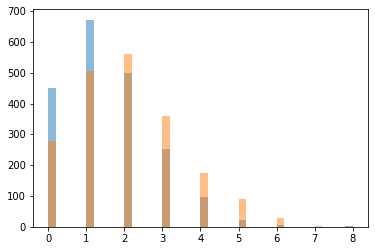

In [11]:
# Discrete poisson

mu=1.5
data_poisson = stats.poisson.rvs(mu=1.5, size=2000)
data_poisson2 = stats.poisson.rvs(mu=2, size=2000)

sample_df_4 = pd.DataFrame(np.array([data_poisson,data_poisson2]).T,columns=['sample_group','control_group'])
#initial dataset
smp_df4=sample_df_4['sample_group'].reset_index().rename(columns={'sample_group': "test_group"})
#control dataset
cntr_df4=sample_df_4['control_group'].reset_index().rename(columns={'control_group': "test_group"})

## Define custom tests

Here we are defining custom test.

First define Mann-Whitney U-rank

sources:

In [12]:
from scipy.stats import mannwhitneyu
def mannwhitneyu_rank(
    reference_data: pd.Series, current_data: pd.Series, feature_type: str, threshold: float,use_continuity: bool = True):
    """Calculate the Mann-Whitney U-rank test between two arrays
    Args:
        reference_data: reference data
        current_data: current data
        feature_type: feature type
        threshold: all values above this threshold means data drift
    Returns:
        pvalue: the p-value for the test depending on alternative and method
        test_result: whether the drift is detected
    """
    wil_p_value = mannwhitneyu(x=reference_data, y=current_data,use_continuity=use_continuity)[1]
    return wil_p_value, wil_p_value < threshold


mann_whitney_u_stat_test = StatTest(
    name="mannw",
    display_name="Mann-Whitney U-rank test",
    func=mannwhitneyu_rank,
    allowed_feature_types=["num"],
    default_threshold=0.05
)

In [13]:
from scipy.stats import epps_singleton_2samp

def _epps_singleton(
    reference_data: pd.Series,
    current_data: pd.Series,
    feature_type: str,
    threshold: float):
    """Run the Epps-Singleton (ES) test of two samples.
    Args:
        reference_data: reference data
        current_data: current data
        threshold: level of significance (default will be 0.05)
    Returns:
        p_value: p-value based on the asymptotic chi2-distribution.
        test_result: whether the drift is detected
    """
    p_value = epps_singleton_2samp(reference_data, current_data)[1]
    return p_value, p_value < threshold


epps_singleton_test = StatTest(
    name="es",
    display_name="Epps-Singleton",
    func=_epps_singleton,
    allowed_feature_types=["num"],
    default_threshold=0.05
)

In [14]:
feature = 'test_group'

stat_test_option1 = DataDriftOptions(num_features_stattest=mann_whitney_u_stat_test)
stat_test_option2 = DataDriftOptions(num_features_stattest=epps_singleton_test)
stat_test_option3 = DataDriftOptions(num_features_stattest='ks')
stat_test_option4 = DataDriftOptions(num_features_stattest='anderson')
stat_test_option5 = DataDriftOptions(num_features_stattest='cramer_von_mises')

data_drift_dataset_tests = TestSuite(tests=[
    TestFeatureValueDrift(column_name=feature, options=stat_test_option1),
    TestFeatureValueDrift(column_name=feature, options=stat_test_option2),
    TestFeatureValueDrift(column_name=feature, options=stat_test_option3),
    TestFeatureValueDrift(column_name=feature, options=stat_test_option4),
    TestFeatureValueDrift(column_name=feature, options=stat_test_option5)
])

In [15]:
#Define function for checking p-values per population

def create_test_result_dataset(data_drift_dataset_tests):
    d=[]

    for tests in data_drift_dataset_tests.as_dict()['tests']:
        d2=[]
        d2.append(tests['parameters']['features']['test_group']['stattest'])
        d2.append(tests['parameters']['features']['test_group']['score'])

        #added the test name and drift score(p-value or distance)
        d.append(d2)

    df = pd.DataFrame(d,columns=['test','p-value'])

    return df

# Run tests

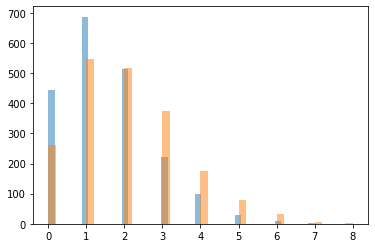

In [129]:
#Poisson distrubution
plt.hist(data_poisson,bins=40,alpha=0.5)
plt.hist(data_poisson2,bins=40,alpha=0.5)
plt.show()

df_n=pd.DataFrame()

for n in range(100,1100,100):
    
    data_drift_dataset_tests.run(reference_data=smp_df4[0:n], current_data=cntr_df4[0:n])
    df = create_test_result_dataset(data_drift_dataset_tests)
    df['data_length'] = n
    df_n=pd.concat([df_n, df])


In [163]:
df_n.head()

,test,p-value,data_length
0,Mann-Whitney U-rank test,0.139,100
1,Epps-Singleton,0.690,100
2,K-S p_value,0.815,100
3,Anderson-Darling,0.250,100
4,cramer_von_mises,0.385,100


<AxesSubplot:xlabel='data_length', ylabel='p-value'>

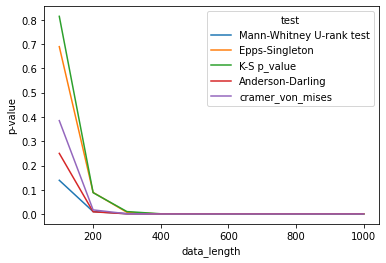

In [164]:
sns.lineplot(
    data=df_n.reset_index(),
    x="data_length", y="p-value", hue="test",
    markers=True
)

"When comparing the incomes of two different groups (especially groups that span the socioeconomic
spectrum), the distributions will likely be highly variable and highly skewed. In such a case,
it might be better to use a nonparametric test like Wilcoxon’s signed-rank test."

"This is a paired test that compares the medians of two distributions"

Ofcourse for this case the Mann-Whitney U test is similar to the Wilcoxon test, but can be used to compare
multiple samples that aren’t necessarily paired.

source: https://www.mit.edu/~6.s085/notes/lecture5.pdf 5.1.3 Wilcoxon’s signed-rank test

Anderson and cramer von mises perform also good at this case

Lets see another case of discreete population dirft:

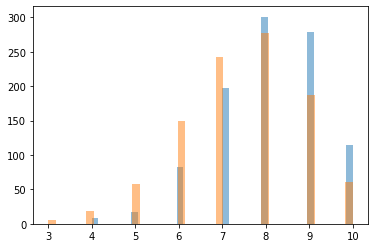

In [130]:
#Binomal distrubution
plt.hist(data_binom,bins=40,alpha=0.5)
plt.hist(data_binom2,bins=40,alpha=0.5)
plt.show()

<AxesSubplot:xlabel='data_length', ylabel='p-value'>

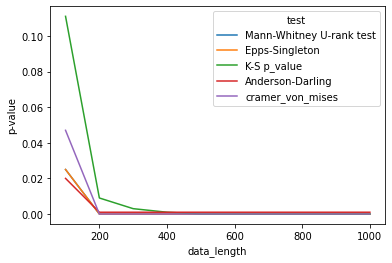

In [131]:
#Binomal distrubution
df_n=pd.DataFrame()

for n in range(100,1100,100):
    
    data_drift_dataset_tests.run(reference_data=smp_df3[0:n], current_data=cntr_df3[0:n])
    df = create_test_result_dataset(data_drift_dataset_tests)
    df['data_length'] = n
    df_n=pd.concat([df_n, df])

sns.lineplot(
    data=df_n.reset_index(),
    x="data_length", y="p-value", hue="test",
    markers=True
)

Again, KS seems to be slower to relize that the two distrubutions are different.

But wait, when is the Mann-Whitney U actually not good at detecting drifts? and KS (as well other tests) better?

Mann-Whitney U mentiones that uses medians to do the tests. So lets try with two normal distrubutions

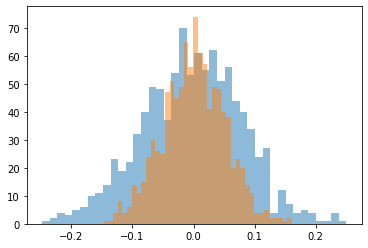

In [132]:
#normal distrubution
plt.hist(r3,bins=40,alpha=0.5)
plt.hist(r4,bins=40,alpha=0.5)
plt.show()

<AxesSubplot:xlabel='data_length', ylabel='p-value'>

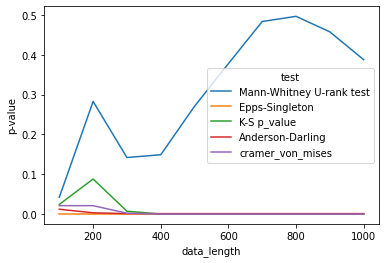

In [133]:
#normal distrubution
df_n=pd.DataFrame()

for n in range(100,1100,100):
    
    data_drift_dataset_tests.run(reference_data=smp_df2[0:n], current_data=cntr_df2[0:n])
    df = create_test_result_dataset(data_drift_dataset_tests)
    df['data_length'] = n
    df_n=pd.concat([df_n, df])

sns.lineplot(
    data=df_n.reset_index(),
    x="data_length", y="p-value", hue="test",
    markers=True
)

As you see here the Mann-Whitney U test never converges to a low p-value as others.


What we are saying is that every test is good for specific cases.

## Choose wisely!!

Want to plug and play?
1) Define your population
2) Run the tests

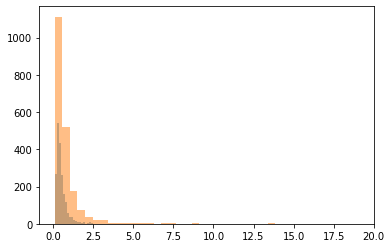

0.8288241989136874 2.760701733872155 -2.5536787452829968 0.850712857742443


In [85]:
a, c = 3, -1.02
mean, var, skew, kurt = stats.gengamma.stats(a, c, moments='mvsk')
r = stats.gengamma.rvs(a, c, size=2000)

a, c = 2.2, -1.02
mean, var, skew, kurt = stats.gengamma.stats(a, c, moments='mvsk')
r2 = stats.gengamma.rvs(a, c, size=2000)

plt.hist(r,bins=40,alpha=0.5)
plt.hist(r2,bins=40,alpha=0.5)
plt.show()
print(mean, var, skew, kurt)

sample_df = pd.DataFrame(np.array([r,r2]).T,columns=['sample_group','control_group'])
#initial dataset
smp_df=sample_df['sample_group'].reset_index().rename(columns={'sample_group': "test_group"})
#control dataset
cntr_df=sample_df['control_group'].reset_index().rename(columns={'control_group': "test_group"})

<AxesSubplot:xlabel='data_length', ylabel='p-value'>

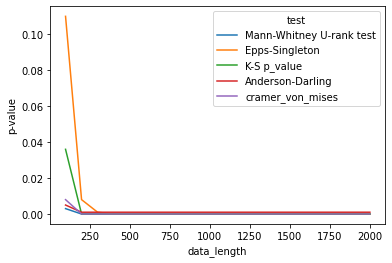

In [86]:
#gen gamma
df_n=pd.DataFrame()

for n in range(100,2100,100):
    
    data_drift_dataset_tests.run(reference_data=smp_df[0:n], current_data=cntr_df[0:n])
    df = create_test_result_dataset(data_drift_dataset_tests)
    df['data_length'] = n
    df_n=pd.concat([df_n, df])

sns.lineplot(
    data=df_n.reset_index(),
    x="data_length", y="p-value", hue="test",
    markers=True
)
